# Auswertung

# Latex Rendering + library import + file reading + primitive plot

In [1]:
# latex rendering
import matplotlib.pyplot as plt 


# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Computer Modern Roman'
plt.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"

import plot_functions as p_func
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

c_scheme = p_func.c_scheme_02()


In [2]:
# load file

fname = "data_aswathi/data/Data_Horiba/20250305/Ne lamp_532nm_400cm-1_20x0p5s_.txt"
STO_2p5 = pd.read_csv(fname, sep="\t")

# STO_2p5.wavenumber
# STO_2p5.counts

STO_2p5

,wavenumber,counts
0,92.9165,67.1579
1,93.5349,34.0000
2,94.1510,74.1053
3,94.7692,83.3684
4,95.3853,84.6316
...,...,...
1019,691.6310,17.2632
1020,692.1900,16.8421
1021,692.7500,13.8947
1022,693.3070,16.1053


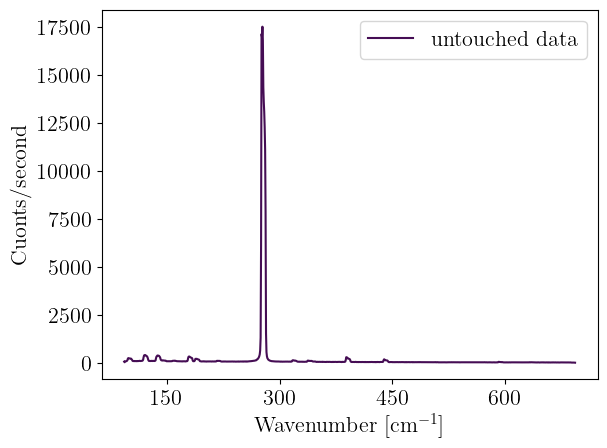

In [3]:
default_data = [
    [STO_2p5.wavenumber, STO_2p5.counts, "untouched data", c_scheme[0], "-", ""]
]

p_func.plot_with_one_axis(default_data, name_x=r"Wavenumber [cm$^{-1}$]", name_y="Cuonts/second", plot_title="", filename_to_save="nosvg", marker_size="5", font_size=16, offset_text_size=16, legend_local="best", legend_size=16, x_ticks_limit=5, x_ticks_numstyle="plain") # [data_x, data_y, label, colorr, line_style, marker_type]


In [4]:
import numpy as np
from scipy.signal import find_peaks, peak_widths
from scipy.optimize import curve_fit

# Define Gaussian
def gaussian(x, amp, x0, sigma):
    return amp * np.exp(-(x - x0)**2 / (2 * sigma**2))

x_data = STO_2p5.wavenumber.values
y_data = STO_2p5.counts.values

x0_list = []

# Step 1: Find peaks
peaks, _ = find_peaks(y_data, height=1000, distance=10)

# Step 2: Estimate FWHM
results_half = peak_widths(y_data, peaks, rel_height=0.5)

# Step 3: Loop over all peaks
for i, peak_index in enumerate(peaks):
    amp = y_data[peak_index]
    x0 = x_data[peak_index]
    fwhm_samples = results_half[0][i]
    fwhm_x = fwhm_samples * (x_data[1] - x_data[0])
    sigma = fwhm_x / 2.355

    # Define fitting window (±1.5 * FWHM)
    half_window = int(np.round(fwhm_samples * 1.5 / 2))
    von = max(0, peak_index - half_window)
    zu = min(len(x_data) - 1, peak_index + half_window)

    # Prepare data and fit
    x_range = x_data[von:zu]
    y_range = y_data[von:zu]
    initial_guess = [amp, x0, sigma]

    try:
        params, covariance = curve_fit(gaussian, x_range, y_range, p0=initial_guess)
        amp_fit, x0_fit, sigma_fit = params
        x0_list.append(x0_fit)
        # print(f"Peak {i+1}")
        # print(f"  Range indices: [{von}:{zu}]")
        # print(f"  Fitted Amplitude: {amp_fit:.2f}")
        # print(f"  Fitted x0:        {x0_fit:.2f}")
        # print(f"  Fitted Sigma:     {sigma_fit:.2f}")
        ## print("")
    except RuntimeError:
        print(f"Peak {i+1}: Fit failed.")

for ele in x0_list:
    print(ele)

278.057233435362


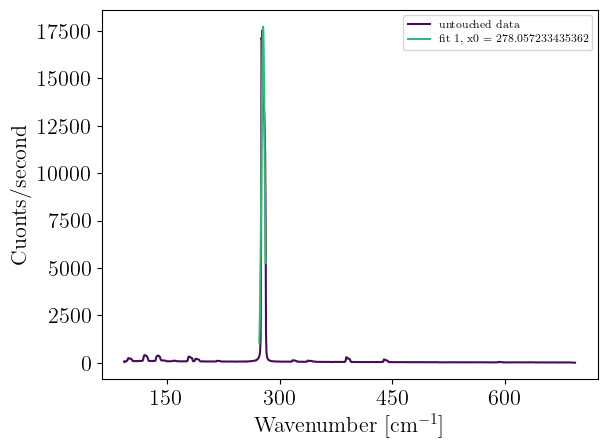

In [5]:
import numpy as np
from scipy.signal import find_peaks, peak_widths
from scipy.optimize import curve_fit

# Gaussian definition
def gaussian(x, amp, x0, sigma):
    return amp * np.exp(-(x - x0)**2 / (2 * sigma**2))

x_data = STO_2p5.wavenumber.values
y_data = STO_2p5.counts.values

# Peak detection
peaks, _ = find_peaks(y_data, height=1000, distance=10)
results_half = peak_widths(y_data, peaks, rel_height=0.5)

# Prepare list for plot
plot_data = [
    [x_data, y_data, "untouched data", c_scheme[0], "-", ""]
]

# Fit Gaussians and add them to plot
for i, peak_index in enumerate(peaks):
    amp = y_data[peak_index]
    x0 = x_data[peak_index]
    fwhm_samples = results_half[0][i]
    fwhm_x = fwhm_samples * (x_data[1] - x_data[0])
    sigma = fwhm_x / 2.355

    half_window = int(np.round(fwhm_samples * 1.5 / 2))
    von = max(0, peak_index - half_window)
    zu = min(len(x_data) - 1, peak_index + half_window)

    x_range = x_data[von:zu]
    y_range = y_data[von:zu]
    initial_guess = [amp, x0, sigma]

    try:
        params, _ = curve_fit(gaussian, x_range, y_range, p0=initial_guess)
        amp_fit, x0_fit, sigma_fit = params

        # Generate smooth fit curve
        x_fit = np.linspace(x_data[von], x_data[zu], 200)
        y_fit = gaussian(x_fit, amp_fit, x0_fit, sigma_fit)

        plot_data.append([x_fit, y_fit, f"fit {i+1}, x0 = {x0_fit}", c_scheme[6], "-", ""])
    except RuntimeError:
        print(f"Fit {i+1} failed.")

# Final plot
p_func.plot_with_one_axis(
    plot_data,
    name_x=r"Wavenumber [cm$^{-1}$]",
    name_y="Cuonts/second",
    plot_title="",
    filename_to_save="nosvg",
    marker_size="5",
    font_size=16,
    offset_text_size=16,
    legend_local="best",
    legend_size=8,
    x_ticks_limit=5,
    x_ticks_numstyle="plain"
)


# linear fit

Fitted parameters:
Slope (m): 0.0004294289382302961
Intercept (b): 0.004442720032935832


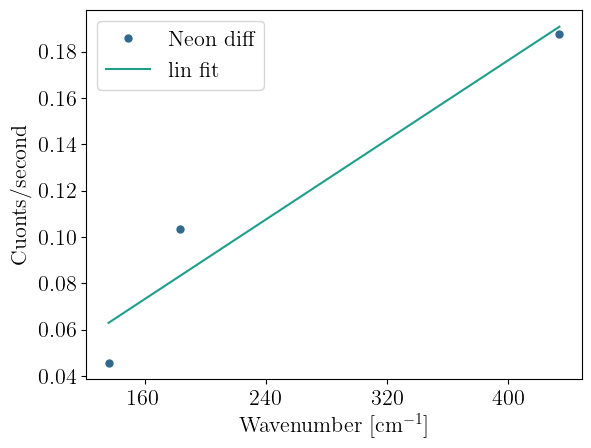

In [99]:
# have a look ad neon excel file

import numpy as np
from scipy.optimize import curve_fit

x_experimental = [136.195751946264, 183.373601993814, 433.787487449207]
y_diff = [0.0457519462635503, 0.103601993813612, 0.187487449206458]



# Define a linear function: y = m*x + b
def linear(x, m, b):
    return m * x + b

# Fit the linear function to your data
initial_guess = [1, 0]  # m=1, b=0
params, covariance = curve_fit(linear, x_experimental, y_diff, p0=initial_guess)

# Unpack fitted parameters
m_fit, b_fit = params

x_fit_lin = np.linspace(x_experimental[0], x_experimental[-1], 100)
y_fit_lin = linear(x_fit_lin, m_fit, b_fit)

# Example usage
print("Fitted parameters:")
print(f"Slope (m): {m_fit}")
print(f"Intercept (b): {b_fit}")

fitting_for_adjusting = [
    [x_experimental, y_diff, "Neon diff", c_scheme[3], "", "o"],
    [x_fit_lin, y_fit_lin, "lin fit", c_scheme[5], "-", ""],
]

p_func.plot_with_one_axis(fitting_for_adjusting, name_x=r"Wavenumber [cm$^{-1}$]", name_y="Cuonts/second", plot_title="", filename_to_save="nosvg", marker_size="5", font_size=16, offset_text_size=16, legend_local="best", legend_size=16, x_ticks_limit=5, x_ticks_numstyle="plain") # [data_x, data_y, label, colorr, line_style, marker_type]


# new x_axis can be added to relevant measurements

this is applicable to all measurements from 20250304

substract from the xaxis (wavenumber) the following: WN_new = WN - (m*WN + b)

This is applied to all files in 20250304 apart neon file itself

In case of only one data point -> m=0, b=b -> WN-new = WN - (b)

